## Библиотеки

In [88]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import bootstrap

import pandahouse as ph

%matplotlib inline

## Данные

In [89]:
# Информация о группе пользователя (тестовая/контрольная)
groups = pd.read_csv('C:/Users/Arthur/Desktop/data/groups.csv', sep=';')

In [90]:
# Информация об активных в день эксперимента пользователях
active_studs = pd.read_csv('C:/Users/Arthur/Desktop/data/active_studs.csv')

In [91]:
# Информация об оплатах пользователей в день эксперимента
checks = pd.read_csv('C:/Users/Arthur/Desktop/data/checks.csv', sep=';')

## 1. Интерпретация результатов A/B тестирования

### Исследование данных

Для начала рассмотрим данные, проверим на наличие дубликатов  
и пропусков, найдём число строк и уникальных значений.

Начнём с таблицы **groups**:

In [92]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [93]:
print(f'Таблица:                groups')
print(f'Строк:                  {groups.shape[0]}')
print(f'Столбцов:               {groups.shape[1]}')
print(f'Дубликатов:             {groups.duplicated().sum()}')
print(f' ')
print(f'Столбец:                {groups.columns[0]}')
print(f'Уникальных значений:    {groups.id.nunique()}')
print(f'Пропусков:              {groups.id.isna().sum()}')
print(f' ')
print(f'Столбец:                {groups.columns[1]}')
print(f'Уникальных значений:    {groups.grp.nunique()}')
print(f'Пропусков:              {groups.grp.isna().sum()}')

Таблица:                groups
Строк:                  74484
Столбцов:               2
Дубликатов:             0
 
Столбец:                id
Уникальных значений:    74484
Пропусков:              0
 
Столбец:                grp
Уникальных значений:    2
Пропусков:              0


Пропуски и дубликаты отсутствуют. Значения **id** уникальны.  
Групп — две: тестовая и контрольная. Данные валидны.

Рассмотрим таблицу **active_studs**:

In [94]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [95]:
print(f'Таблица:                active_studs')
print(f'Строк:                  {active_studs.shape[0]}')
print(f'Столбцов:               {active_studs.shape[1]}')
print(f'Дубликатов:             {active_studs.duplicated().sum()}')
print(f' ')
print(f'Столбец:                {active_studs.columns[0]}')
print(f'Уникальных значений:    {active_studs.student_id.nunique()}')
print(f'Пропусков:              {active_studs.student_id.isna().sum()}')

Таблица:                active_studs
Строк:                  8341
Столбцов:               1
Дубликатов:             0
 
Столбец:                student_id
Уникальных значений:    8341
Пропусков:              0


Пропуски и дубликаты отсутствуют. Значения **id** уникальны. Данные валидны.

Рассмотрим таблицу **checks**:

In [96]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [97]:
print(f'Таблица:                checks')
print(f'Строк:                  {checks.shape[0]}')
print(f'Столбцов:               {checks.shape[1]}')
print(f'Дубликатов:             {checks.duplicated().sum()}')
print(f' ')
print(f'Столбец:                {checks.columns[0]}')
print(f'Уникальных значений:    {checks.student_id.nunique()}')
print(f'Пропусков:              {checks.student_id.isna().sum()}')
print(f' ')
print(f'Столбец:                {checks.columns[1]}')
print(f'Уникальных значений:    {checks.rev.nunique()}')
print(f'Пропусков:              {checks.rev.isna().sum()}')

Таблица:                checks
Строк:                  541
Столбцов:               2
Дубликатов:             0
 
Столбец:                student_id
Уникальных значений:    541
Пропусков:              0
 
Столбец:                rev
Уникальных значений:    39
Пропусков:              0


Пропуски и дубликаты отсутствуют. Значения **id** уникальны.  
Уникальных сумм покупки — 39. Данные валидны.

### Объединение данных

Создаём общий датафрейм используя LEFT JOIN'ы к таблице **groups**.  
Таким образом, в датафрейм не войдут данные об активных пользователях  
без группы и о платящих пользователях без группы, если такие есть.  
В любом случае мы не можем использовать эту информацию в контексте A/B теста.

Перед тем как производить JOIN'ы, переименуем колонку **id** в **student_id**  
в таблице **groups** для консистентности таблиц, а также создадим фиктивную  
переменную **active** для **active_studs** и **payer** для **checks**, чтобы упростить  
дальнейшие расчёты.

In [98]:
groups = groups.rename(columns={'id' : 'student_id'})

In [99]:
active_studs['active'] = 1

In [100]:
checks['payer'] = 1

In [101]:
df = groups.merge(active_studs, how='left', on='student_id') \
           .merge(checks,       how='left', on='student_id')

In [102]:
df.head()

,student_id,grp,active,rev,payer
0,1489,B,NaN,NaN,NaN
1,1627,A,1.0,990.0,1.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN


Заменим NaN значения фиктивных переменных на 0 и приведём  
их к целочисленному типу данных.

In [103]:
df['active'] = df.active.fillna(0)
df['active'] = df.active.astype('int64')

In [104]:
df['payer'] = df.payer.fillna(0)
df['payer'] = df.payer.astype('int64')

In [105]:
df.head()

,student_id,grp,active,rev,payer
0,1489,B,0,NaN,0
1,1627,A,1,990.0,1
2,1768,B,0,NaN,0
3,1783,B,0,NaN,0
4,1794,A,0,NaN,0


Заполним NaN значения столбца **rev** нулём для корректного расчёта метрик.  
По той же причине ограничим длину значений **rev** 2-мя символами после запятой.

In [106]:
df['rev'] = df.rev.fillna(0)
df['rev'] = df.rev.round(2)

In [107]:
df.head()

,student_id,grp,active,rev,payer
0,1489,B,0,0.0,0
1,1627,A,1,990.0,1
2,1768,B,0,0.0,0
3,1783,B,0,0.0,0
4,1794,A,0,0.0,0


Изменим порядок столбцов и переименуем их для удобства.

In [108]:
df = df.rename(columns={'grp' : 'group',
                        'rev' : 'revenue'})

In [109]:
df = df[['student_id', 'group', 'revenue', 'active', 'payer']]

In [110]:
df.head()

,student_id,group,revenue,active,payer
0,1489,B,0.0,0,0
1,1627,A,990.0,1,1
2,1768,B,0.0,0,0
3,1783,B,0.0,0,0
4,1794,A,0.0,0,0


Проверим наличие неактивных пользователей, которые совершили покупку  
в период эксперимента.

In [111]:
df[(df.revenue > 0) & (df.active == 0)]

,student_id,group,revenue,active,payer
39,3185,B,690.0,0,1
121,25973,B,690.0,0,1
125,26280,B,690.0,0,1
223,100645,B,630.0,0,1
254,102534,B,580.0,0,1
...,...,...,...,...,...
72452,5291900,B,199.0,0,1
72753,5331842,B,290.0,0,1
73632,5486319,B,199.0,0,1
74049,5562806,B,398.0,0,1


В датафрейме 149 неактивных пользователей, совершивших покупку в период  
эксперимента. Скорее всего это ранее подписавшиеся пользователи  
с автоматическим продлением. Т.е. они не были активны в период введения  
новой механики оплаты, значит мы не знаем насколько на факт их оплаты  
повлиял эксперимент.

### Статистические тесты

Можем приступать к статистическим тестам. Для начала отфильтруем только  
активных в период эксперимента пользователей и удалим колонку **active**,  
т.к. все её значеничя будут одинаковы.

In [112]:
exp = df[df.active == 1]

In [113]:
exp = exp[['student_id', 'group', 'revenue', 'payer']]

In [114]:
exp.head()

,student_id,group,revenue,payer
1,1627,A,990.0,1
10,2085,B,0.0,0
12,2215,B,0.0,0
43,3391,A,0.0,0
45,3401,B,0.0,0


Определим метрики, которые будем сравнивать:

* CR (Conversion Rate) — доля пользователей совершивших покупку
* ARPU (Average Revenue Per User) — прибыль с одного пользователя
* ARPPU (Average Revenue Per Paying User) — прибыль с одного платящего  
                                            пользователя


Проверим число наблюдений в каждой из групп, также создадим два  
датафрейма: контроль и тест.

In [115]:
print(f'Число наблюдений')
print(f'Контрольная группа:      {exp.group.value_counts()[1]}')
print(f'Тестовая группа:         {exp.group.value_counts()[0]}')


Число наблюдений
Контрольная группа:      1535
Тестовая группа:         6793


In [116]:
exp_control = exp[exp.group == 'A']

In [117]:
exp_control.head()

,student_id,group,revenue,payer
1,1627,A,990.0,1
43,3391,A,0.0,0
331,109623,A,0.0,0
614,133678,A,0.0,0
1002,175944,A,0.0,0


In [118]:
exp_test = exp[exp.group == 'B']

In [119]:
exp_test.head()

,student_id,group,revenue,payer
10,2085,B,0.0,0
12,2215,B,0.0,0
45,3401,B,0.0,0
112,22994,B,0.0,0
159,26899,B,0.0,0


Начнём со сравнения CR. Так как конверсионные метрики описываются   
распределением Бернулли, для анализа их изменений применим  
Z-тест пропорций. Но прежде взглянем на CR в каждой группе.

In [120]:
print(f'CR')
print(f'Контрольная группа:     {(exp_control.payer.sum() / exp_control.payer.count() * 100).round(2)}%')
print(f'Тестовая группа:        {(exp_test.payer.sum() / exp_test.payer.count() * 100).round(2)}%')


CR
Контрольная группа:     5.08%
Тестовая группа:        4.61%


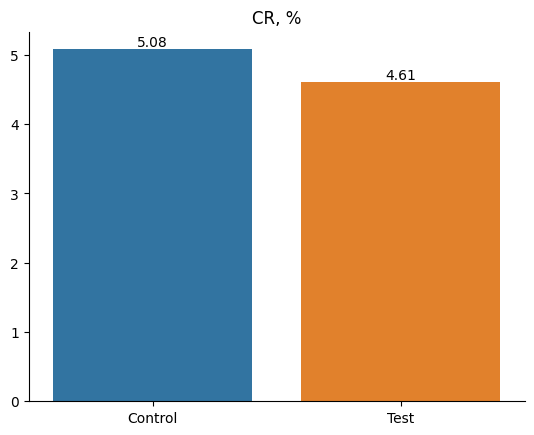

In [121]:
data = [(exp_control.payer.sum() / exp_control.payer.count() * 100).round(2),
        (exp_test.payer.sum() / exp_test.payer.count() * 100).round(2)]

ax = sns.barplot(x=['Control', 'Test'], y=data)
ax.set_title('CR, %')
for i in ax.containers:
    ax.bar_label(i,)
sns.despine()

Перейдём к тестам.   
Сформулируем гипотезы:

* H<sub>0</sub>: CR в тестовой и контрольной группе не отличаются;
* H<sub>1</sub>: CR в тестовой и контрольной группе различны.

In [122]:
z_stat, p_value = proportions_ztest([exp_control.payer.sum(),   exp_test.payer.sum()],
                                    [exp_control.payer.count(), exp_test.payer.count()])

In [123]:
print(f'z-статистика:   {z_stat.round(3)}')
print(f'p-value:        {p_value.round(3)}')

z-статистика:   0.792
p-value:        0.428


In [124]:
alpha = 0.05
if p_value <= alpha:
    print('Отклоняем H0.')
else:
    print('НЕ отклоняем H0.')

НЕ отклоняем H0.


Так как p-value ≈ 0.428, что больше уровня уровня значимости в 0.05,  
мы не отклоняем H0 и считаем, что влияние новой механики оплаты  
на конверсию в оплату не является статистически значимым.

Далее сравним ARPU. Для начала рассмотрим их значения в каждой группе.

In [125]:
print(f'ARPU')
print(f'Контрольная группа:     {exp_control.revenue.mean().round(2)}')
print(f'Тестовая группа:        {exp_test.revenue.mean().round(2)}')

ARPU
Контрольная группа:     47.44
Тестовая группа:        57.86


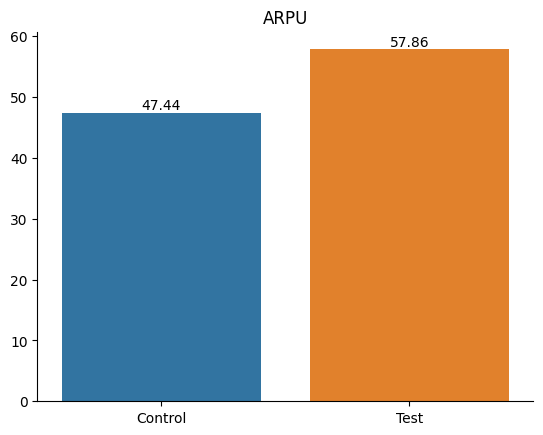

In [126]:
data = [exp_control.revenue.mean().round(2),
        exp_test.revenue.mean().round(2)]

ax = sns.barplot(x=['Control', 'Test'], y=data)
ax.set_title('ARPU')
for i in ax.containers:
    ax.bar_label(i,)
sns.despine()

И взглянем на распределения.

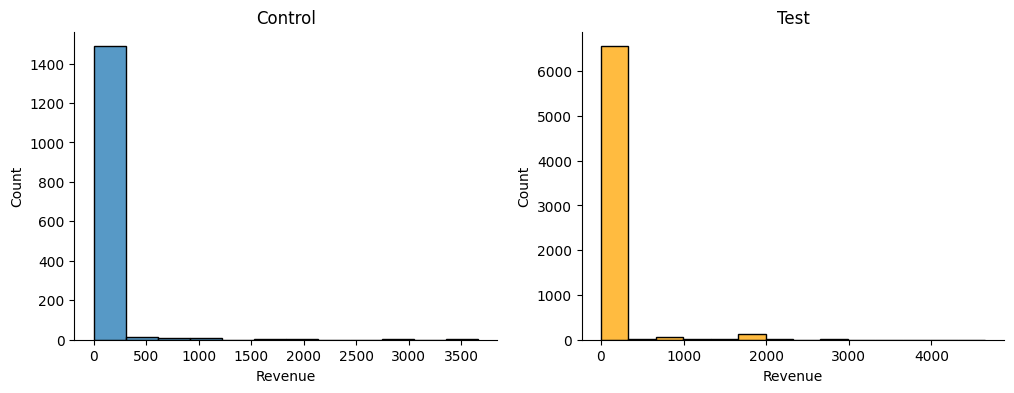

In [127]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(exp_control, x='revenue', ax=axes[0])
axes[0].set_title('Control')
axes[0].set_xlabel('Revenue')
sns.despine()

sns.histplot(exp_test, x='revenue', ax=axes[1], color='orange')
axes[1].set_title('Test')
axes[1].set_xlabel('Revenue')
sns.despine()

Распределения обеих групп отличны от нормального, применим bootstrap  
для приведения распределений к нормальному виду.

In [128]:
test_arpu_bootstrap = bootstrap((exp_test.revenue, ), np.mean) \
                               .bootstrap_distribution
control_arpu_bootstrap = bootstrap((exp_control.revenue, ), np.mean) \
                                  .bootstrap_distribution

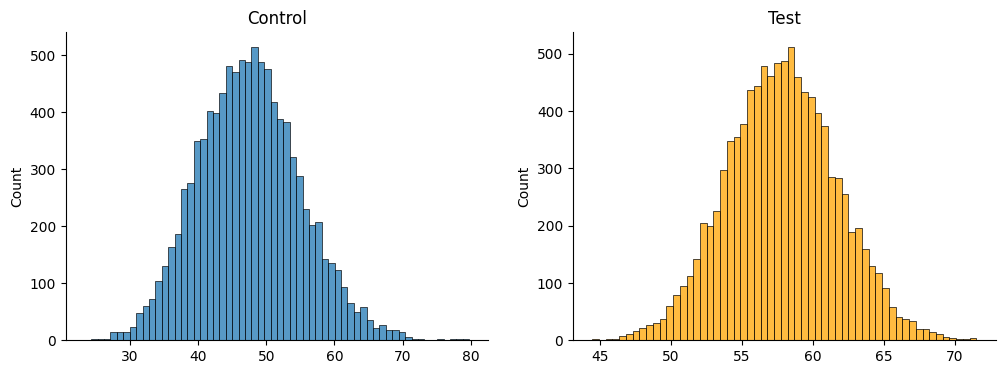

In [129]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(control_arpu_bootstrap, ax=axes[0])
axes[0].set_title('Control')
sns.despine()

sns.histplot(test_arpu_bootstrap, ax=axes[1], color='orange')
axes[1].set_title('Test')
sns.despine()

Найдём разность распределений, построим 95% доверительный интервал  
и отметим ноль.  
Также сформулируем гипотезы:

* H<sub>0</sub>: ARPU в тестовой и контрольной группе не отличаются;
* H<sub>1</sub>: ARPU в тестовой и контрольной группе различны.

In [130]:
diff_arpu_bootstrap = test_arpu_bootstrap - control_arpu_bootstrap

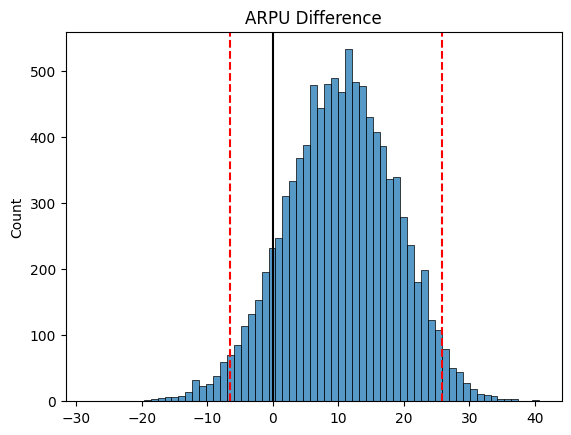

In [131]:
ax = sns.histplot(diff_arpu_bootstrap)
ax.set_title('ARPU Difference')

ci = np.percentile(diff_arpu_bootstrap, [2.5, 97.5])

plt.axvline(0, color='k', linestyle='-')
plt.axvline(ci[0], color='r', linestyle='--')
plt.axvline(ci[1], color='r', linestyle='--')
plt.show()

Как видно из графика вероятность получить 0 находится в пределе 95%  
доверительного интервала, следовательно, нет никаких оснований отклонять H0 —  
статзначимых различий ARPU в тестовой и контрольной группе не обнаружено.

Проверим ARPPU. Отфильтруем только платящих пользователей  
и рассмотрим значения в каждой группе.

In [132]:
exp_control_payer = exp_control[exp_control.payer == 1]
exp_test_payer = exp_test[exp_test.payer == 1]

In [133]:
print(f'ARPPU')
print(f'Контрольная группа:     {exp_control_payer.revenue.mean().round(2)}')
print(f'Тестовая группа:        {exp_test_payer.revenue.mean().round(2)}')

ARPPU
Контрольная группа:     933.59
Тестовая группа:        1255.83


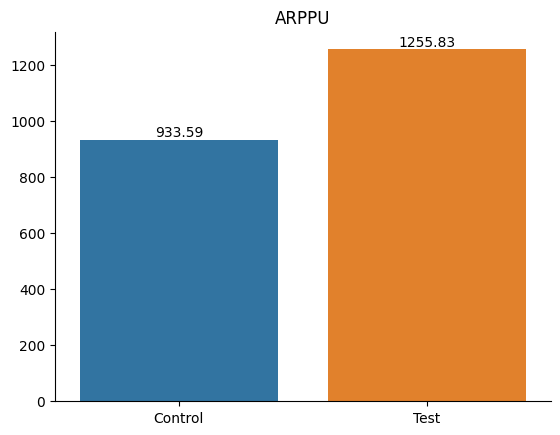

In [134]:
data = [exp_control_payer.revenue.mean().round(2),
        exp_test_payer.revenue.mean().round(2)]

ax = sns.barplot(x=['Control', 'Test'], y=data)
ax.set_title('ARPPU')
for i in ax.containers:
    ax.bar_label(i,)
sns.despine()

Рассмотрим распределения.

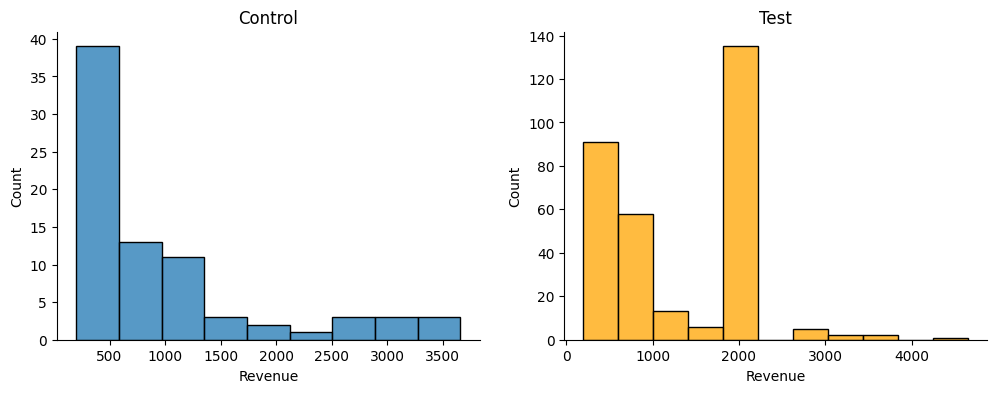

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(exp_control_payer, x='revenue', ax=axes[0])
axes[0].set_title('Control')
axes[0].set_xlabel('Revenue')
sns.despine()

sns.histplot(exp_test_payer, x='revenue', ax=axes[1], color='orange')
axes[1].set_title('Test')
axes[1].set_xlabel('Revenue')
sns.despine()

Распределения не нормальные, но прежде чем применять bootstrap рассмотрим  
структуру оплат

In [136]:
revenue_distribution = exp[exp.payer == 1] \
                          .groupby((['revenue', 'group'])) \
                          .agg({'student_id' : 'count'}) \
                          .reset_index()

In [137]:
revenue_distribution.head()

,revenue,group,student_id
0,199.0,A,5
1,199.0,B,27
2,290.0,A,25
3,290.0,B,45
4,398.0,A,1


In [138]:
pivot_revenue_distribution = revenue_distribution.pivot(index='revenue',
                                                        columns='group',
                                                        values='student_id') \
                                                 .sort_values(['B', 'A'],
                                                        ascending=[False, False])

In [139]:
pivot_revenue_distribution.head(10)

group,A,B
revenue,,
1900.0,NaN,127.0
290.0,25.0,45.0
199.0,5.0,27.0
840.0,3.0,21.0
990.0,5.0,17.0
690.0,4.0,13.0
1140.0,2.0,9.0
590.0,5.0,6.0
398.0,1.0,6.0


Как видно из таблицы в контрольной группе отсутствуют оплаты размером 1900,  
в то время как в тестовой группе их аномально много. Из чего следует вывод,  
что новая механика оплаты связана с этой цифрой.

Вернёмся к ARPPU. Используем bootstrap для приведения распределения  
к нормальному виду.

In [140]:
test_arppu_bootstrap = bootstrap((exp_test_payer.revenue, ), np.mean) \
                               .bootstrap_distribution
control_arppu_bootstrap = bootstrap((exp_control_payer.revenue, ), np.mean) \
                                  .bootstrap_distribution

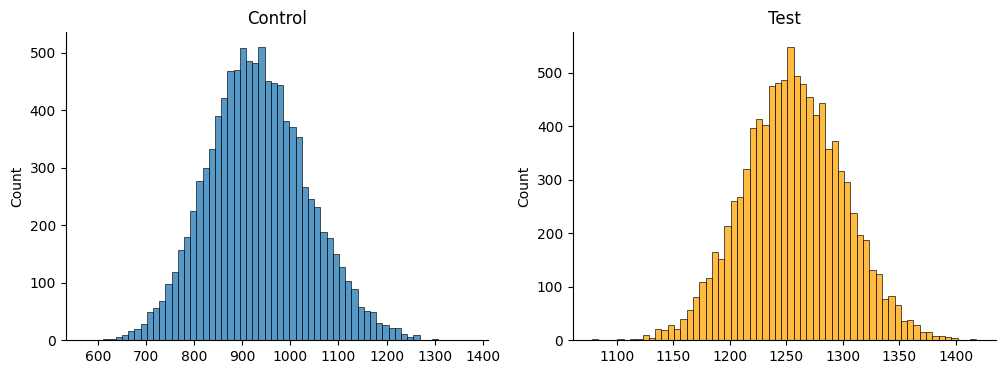

In [141]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(control_arppu_bootstrap, ax=axes[0])
axes[0].set_title('Control')
sns.despine()

sns.histplot(test_arppu_bootstrap, ax=axes[1], color='orange')
axes[1].set_title('Test')
sns.despine()

Найдём разность распределений, построим 95% доверительный интервал  
и отметим ноль.  
Также сформулируем гипотезы:

* H<sub>0</sub>: ARPPU в тестовой и контрольной группе не отличаются;
* H<sub>1</sub>: ARPPU в тестовой и контрольной группе различны.

In [142]:
diff_arppu_bootstrap = test_arppu_bootstrap - control_arppu_bootstrap

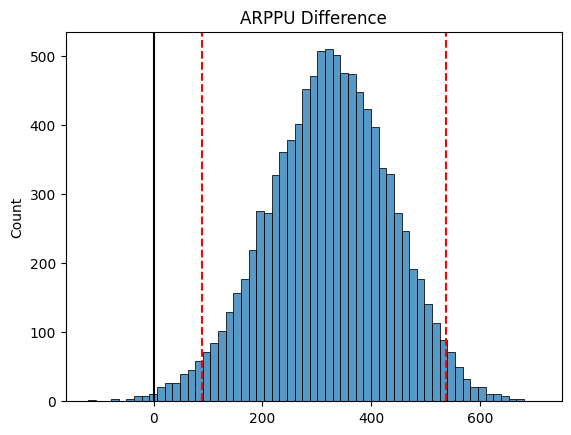

In [143]:
ax = sns.histplot(diff_arppu_bootstrap)
ax.set_title('ARPPU Difference')

ci = np.percentile(diff_arppu_bootstrap, [2.5, 97.5])

plt.axvline(0, color='k', linestyle='-')
plt.axvline(ci[0], color='r', linestyle='--')
plt.axvline(ci[1], color='r', linestyle='--')
plt.show()

Как видно из графика вероятность получить 0 находится вне предела 95%  
доверительного интервала, есть основания для отклонения H0  —  
статзначимых различия ARPPU в тестовой и контрольной группе обнаружены.

### Вывод

В ходе проведения A/B теста обнаружено:

* Различие CR в группах НЕ статзначимы;
* Различие ARPU в группах НЕ статзначимы;
* Различие ARPPU в группах статзначимо.  
Средний чек пользователей в тестовой группе вырос.

Запускаем новую механику оплаты для всех пользователей.

## 2. SQL

### 2.1 Очень усердные ученики

Дана таблица **default.peas**:

| Название атрибута | Тип атрибута | Смысловое значение                         |
|-------------------|--------------|--------------------------------------------|
| st_id             | int          | ID ученика                                 |
| timest            | timestamp    | Время решения карточки                     |
| correct           | bool         | Правильно ли решено задание                |
| subject           | text         | Дисциплина, в которой находится задание    |

Необходимо написать оптимальный запрос, который даст информацию о количестве  
очень усердных студентов. NB! Под усердным студентом мы понимаем студента,  
который правильно решил 20 задач за текущий месяц.

In [144]:
# Настроим подключение к ClickHouse
connection = {'host'     : 'https://clickhouse.lab.karpov.courses',
              'database' : 'default',
              'user'     : 'student', 
              'password' : 'dpo_python_2020'}

Напишем функцию, возвращающую результат запроса к ClickHouse.

In [145]:
def sql(query):
    sql_request = ph.read_clickhouse(query=query, connection=connection)
    return sql_request

Далее напишем запрос, считающий число правильных заданий в текущий  
(максимальный) месяц для каждого пользователя, корректно решившего  
20 и более заданий. Поместим его в подзапрос и вычислим число  
усердных студентов.

In [146]:
query = '''
        SELECT COUNT(st_id) AS diligent_students
        FROM   (SELECT   st_id,
                         SUM(correct) AS correct_tasks
                FROM     default.peas
                WHERE    DATE_TRUNC('month', timest) = (SELECT DATE_TRUNC('month', MAX(timest))
                                                      FROM   default.peas)
                GROUP BY st_id
                HAVING   SUM(correct) >= 20);
        '''

In [147]:
sql(query)

,diligent_students
0,136


### 2.2 Оптимизация воронки

Помимо таблицы **defaul.peas** дана таблица **default.studs**:

| Название атрибута | Тип атрибута | Смысловое значение                     |
|-------------------|--------------|----------------------------------------|
| st_id             | int          | ID ученика                             |
| test_grp          | text         | Метка ученика в данном эксперименте    |


И таблица **default.final_project_check**:

| Название атрибута | Тип атрибута | Смысловое значение                         |
|-------------------|--------------|--------------------------------------------|
| st_id             | int          | ID ученика                                 |
| sale_time         | timestamp    | Время покупки                              |
| money             | int          | Цена, по которой приобрели данный курс     |
| subject           | text         | Дисциплина курса                           |

Необходимо в одном запросе выгрузить следующую информацию  
о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’)  
в покупку курса по математике
* ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач  
правильно в любых дисциплинах.  

Активным по математике считается пользователь, за все время решивший  
2 или больше задач правильно по математике.

Для начала начала создадим фиктивные переменные **active** для пользователей,  
решивших 10 и более заданий, и **active_math** для тех кто решил 2 и более  
задания по математике.

In [148]:
query = '''
        SELECT   st_id,
                 IF(SUM(correct) >= 10, 1, 0) AS active,
                 IF(SUM(correct) FILTER (WHERE subject = 'Math') >= 2, 1, 0) AS active_math
        FROM     peas
        GROUP BY st_id;
        '''

In [149]:
sql(query).head(5)

,st_id,active,active_math
0,414769,1,0
1,878110,0,0
2,700123,1,0
3,171209,1,0
4,289442,1,0


In [150]:
sql(query).shape

(308, 3)

Далее найдём траты пользователей на покупку курсов по математике и на покупку  
всех курсов (включая математику).

In [151]:
query = '''
        SELECT DISTINCT st_id,
               SUM(money) OVER (PARTITION BY st_id) AS revenue,
               SUM(money) FILTER (WHERE subject = 'Math') OVER (PARTITION BY st_id) AS math_revenue
        FROM   final_project_check;
        '''

In [152]:
sql(query).head(5)

,st_id,revenue,math_revenue
0,101432,150000,85000
1,104885,140000,0
2,106464,85000,85000
3,114606,75000,0
4,147316,65000,0


In [153]:
sql(query).shape

(47, 3)

Поместим предыдущие запросы в CTE. К таблице с группой пользователя  
при помощи LEFT JOIN присоединим информацию об активных пользователях  
и о тратах пользователей.

In [154]:
query = '''
        WITH active_studs AS (SELECT   st_id,
                                       IF(SUM(correct) >= 10, 1, 0) AS active,
                                       IF(SUM(correct) FILTER (WHERE subject = 'Math') >= 2, 1, 0) AS active_math
                              FROM     peas
                              GROUP BY st_id),
                                
                 payments AS (SELECT DISTINCT st_id,
                                     SUM(money) OVER (PARTITION BY st_id) AS revenue,
                                     SUM(money) FILTER (WHERE subject = 'Math') OVER (PARTITION BY st_id) AS math_revenue
                              FROM   final_project_check)
                        
SELECT    studs.st_id AS student_id,
          studs.test_grp AS group,
          active_studs.active AS active,
          active_studs.active_math AS active_math,
          payments.revenue AS revenue,
          payments.math_revenue AS revenue_math
FROM      studs
LEFT JOIN active_studs  ON studs.st_id = active_studs.st_id
LEFT JOIN payments      ON studs.st_id = payments.st_id;
        '''

In [155]:
sql(query).head(5)

,student_id,group,active,active_math,revenue,revenue_math
0,100379,pilot,1,0,0,0
1,101432,control,1,0,150000,85000
2,104818,pilot,0,0,0,0
3,104885,pilot,0,0,140000,0
4,104966,pilot,1,0,0,0


In [156]:
sql(query).shape

(600, 6)

Поместим итоговый запрос к двум подзапросам и вычислим необходимые метрики в разрезе групп пользователей

In [157]:
query = '''
        WITH active_studs AS (SELECT   st_id,
                                       IF(SUM(correct) >= 10, 1, 0) AS active,
                                       IF(SUM(correct) FILTER (WHERE subject = 'Math') >= 2, 1, 0) AS active_math
                              FROM     peas
                              GROUP BY st_id),
                                
                 payments AS (SELECT DISTINCT st_id,
                                     SUM(money) OVER (PARTITION BY st_id) AS revenue,
                                     SUM(money) FILTER (WHERE subject = 'Math') OVER (PARTITION BY st_id) AS math_revenue
                              FROM   final_project_check),
                        
                 studs_ab AS (SELECT    studs.st_id AS student_id,
                                        studs.test_grp AS group,
                                        active_studs.active AS active,
                                        active_studs.active_math AS active_math,
                                        payments.revenue AS revenue,
                                        payments.math_revenue AS revenue_math
                              FROM      studs
                              LEFT JOIN active_studs  ON studs.st_id = active_studs.st_id
                              LEFT JOIN payments      ON studs.st_id = payments.st_id)

        SELECT   group,
                 ROUND(SUM(revenue) / COUNT(student_id), 2) AS ARPU,
                 ROUND((SUM(revenue) FILTER (WHERE active + active_math > 0)) / (COUNT(student_id) FILTER (WHERE active + active_math > 0)), 2) AS ARPAU,
                 ROUND((COUNT(student_id) FILTER (WHERE revenue > 0)) / COUNT(student_id) * 100, 2) AS CR_to_purchase,
                 ROUND((COUNT(student_id) FILTER (WHERE revenue > 0 AND active + active_math > 0)) / (COUNT(student_id) FILTER (WHERE active + active_math > 0)) * 100, 2) AS CR_to_purchase_active,
                 ROUND((COUNT(student_id) FILTER (WHERE revenue_math > 0 AND active_math > 0)) / (COUNT(student_id) FILTER (WHERE active_math > 0)) * 100, 2) AS CR_to_purchase_active_math
        FROM     studs_ab
        GROUP BY group;
        '''

In [158]:
sql(query)

,group,ARPU,ARPAU,CR_to_purchase,CR_to_purchase_active,CR_to_purchase_active_math
0,control,4540.98,9565.22,4.92,10.14,6.12
1,pilot,11508.47,26071.43,10.85,23.21,9.52


### 3.1 Подгрузка дополнительных данных

Реализуйте функцию, которая будет автоматически подгружать информацию  
из дополнительного файла groups_add.csv и на основании дополнительных  
параметров пересчитывать метрики.

In [159]:
# Путь к подгружаемому файлу
path = 'C:/Users/Arthur/Desktop/data/group_add.csv'

In [160]:
def group_add(path):

    import pandas as pd
    import numpy as np

    groups = pd.read_csv('C:/Users/Arthur/Desktop/data/groups.csv', sep=';')
    active_studs = pd.read_csv('C:/Users/Arthur/Desktop/data/active_studs.csv')
    checks = pd.read_csv('C:/Users/Arthur/Desktop/data/checks.csv', sep=';')
    
    # Считываем новую таблицу
    new_info = pd.read_csv(path, sep=',')
    
    # Создаём фиктивные переменные, чтобы отличать активных и платящих
    # пользователей на итоговой таблице
    active_studs['active'] = 1
    checks['payer'] = 1
    
    # Сначала джойним информацию о пропущенных пользователях "вниз"
    # (добавляем новые строчки), затем переименовываем колонку,  
    # чтобы не двоить колонки и джойним информацию об активности
    # и об оплатах
    df = groups.merge(new_info, how='outer', on=['id', 'grp'])
    df = df.rename(columns={'id' : 'student_id'})
    df = df.merge(active_studs, how='left', on='student_id') \
           .merge(checks,       how='left', on='student_id')
    
    # Заполняем пропуски нулём и округляем значения для корректных расчётов
    df['active'] = df.active.fillna(0)
    df['active'] = df.active.astype('int64')
    df['payer'] = df.payer.fillna(0)
    df['payer'] = df.payer.astype('int64')
    df['rev'] = df.rev.fillna(0)
    df['rev'] = df.rev.round(2)
    
    # Отбираем только активных в день эксперимента пользователей
    df = df[df.active == 1]
    
    # Расчитываем метрики
    control = df[df.grp == 'A']
    control_CR = round(control.payer.sum() / control.payer.count() * 100, 2)
    control_ARPU = control.rev.mean().round(2)
    control_ARPPU = control[control.payer == 1].rev.mean().round(2)

    test = df[df.grp == 'B']
    test_CR = round(test.payer.sum() / test.payer.count() * 100, 2)
    test_ARPU = test.rev.mean().round(2)
    test_ARPPU = test[test.payer == 1].rev.mean().round(2)
    
    # Строим таблицу с метриками
    metrics = {'Group': ['Control', 'Test'], 'CR' : [control_CR, test_CR],
               'ARPU' : [control_ARPU, test_ARPU], 'ARPPU' : [control_ARPPU, test_ARPPU]}
    metrics_df = pd.DataFrame(metrics)

    return metrics_df

In [161]:
group_add(path)

,Group,CR,ARPU,ARPPU
0,Control,5.07,47.35,933.59
1,Test,4.62,58.06,1257.88


### 3.2 Визуализация метрик

In [162]:
def group_add_viz(path):

    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline

    metrics = group_add(path)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    ax = sns.barplot(data=metrics, x='Group', y='CR', ax=axes[0])
    for i in ax.containers:
        ax.bar_label(i,)
    axes[0].set_title('CR, %')
    axes[0].set_ylabel('')
    axes[0].set_xlabel('')

    ax = sns.barplot(data=metrics, x='Group', y='ARPU', ax=axes[1])
    for i in ax.containers:
        ax.bar_label(i,)
    axes[1].set_title('ARPU')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('')

    ax = sns.barplot(data=metrics, x='Group', y='ARPPU', ax=axes[2])
    for i in ax.containers:
        ax.bar_label(i,)
    axes[2].set_title('ARPPU')
    axes[2].set_ylabel('')
    axes[2].set_xlabel('')

    sns.despine()
    

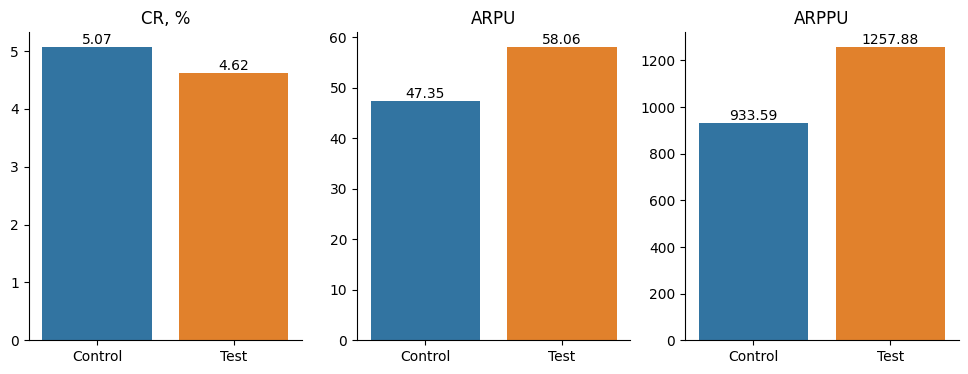

In [163]:
group_add_viz(path)